# Load the CSV
We load the csv file created by the scraper in first part.


In [61]:
from pathlib import Path

import pandas as pd
from pandas import DataFrame

from utils import get_path

tweet_path: Path = get_path("./tweets.csv")
df: DataFrame = pd.read_csv(tweet_path, parse_dates=['created_at'], date_format='%a %b %d %H:%M:%S %z %Y',
                            dtype={'id': int,
                                   'username': 'string',
                                   'text': 'string',
                                   'retweets': int,
                                   'likes': int})
df.set_index('id', inplace=True)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2046 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   username    2046 non-null   string             
 1   text        2046 non-null   string             
 2   created_at  2046 non-null   datetime64[ns, UTC]
 3   retweets    2046 non-null   int64              
 4   likes       2046 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(2), string(2)
memory usage: 95.9 KB


,retweets,likes
count,2046.000000,2046.000000
mean,194.176442,2125.005865
std,362.382369,3535.550454
min,0.000000,0.000000
25%,1.000000,14.000000
50%,34.000000,432.000000
75%,224.000000,2752.750000
max,4186.000000,27222.000000


## General infos

In [62]:
df.head()

,username,text,created_at,retweets,likes
id,,,,,
0,fra ☆ SAW LOUIS,il bambino a 6 anni a suonare un pianoforte ...,2025-02-12 21:20:28+00:00,1166,9656
1,emma 💐💐,"""e poi praticamente fiorello ha ballato il bal...",2025-02-12 22:21:41+00:00,798,7666
2,𝓒𝓪𝓻𝓶𝓮𝓷 🌙💐,Carlo Conti che ride con Nino Frassica ma poi...,2025-02-12 22:54:56+00:00,783,10251
3,☾ fe💐è esaurita,L’Italia è una repubblica fondata su Nino Fras...,2025-02-12 20:53:58+00:00,1085,9369
4,× linda × • Sanremo Edition💐,Il bambino che a 6 anni sa suonare il pianofor...,2025-02-12 21:15:58+00:00,291,2930


## Numerics

In [63]:
most_retweeted = df.nlargest(10, "retweets")[["username", "text", "retweets"]]
most_retweeted

,username,text,retweets
id,,,
6,soffietta 💐sanremo era,Posso fingere di star bene ma mi manchi #Sanre...,4186
193,Elena 🌾,Carlo Conti appena finiscono di cantare #Sanre...,3184
93,b(itch)🦋,carlo conti che manda via i cantanti dsl palco...,2805
30,🍓,Carlo Conti appena qualcuno (Gerry) fa una bat...,2763
342,marcolè,La velocità con cui Carlo Conti sta facendo es...,2700
45,zia bea💐,posso far finta di star bene ma mi mancano i c...,2473
58,Sab ❁,Comunque mi manca proprio l’imprevedibilità e...,2328
603,moon 🧚‍♀️ 💐 Sanremo 2025💐✨️,"""Dovresti andare a lavorare e non farti mangan...",2236
111,lucrezia ⭑ calmocobra 💐,quest’anno il cast di sanremo voleva fare il c...,2205


In [64]:

most_liked = df.nlargest(10, "likes")[["username", "text", "likes"]]
most_liked


,username,text,likes
id,,,
30,🍓,Carlo Conti appena qualcuno (Gerry) fa una bat...,27222
193,Elena 🌾,Carlo Conti appena finiscono di cantare #Sanre...,26702
26,n (taylor’s version),Non mi sto sentendo bene #Sanremo2025 https://...,26562
46,Gabrielobelo,Il bambino che si commuove perché non sapeva c...,25723
24,anto⚡️,i meme su damiano dei maneskin erano divertent...,21885
93,b(itch)🦋,carlo conti che manda via i cantanti dsl palco...,21814
342,marcolè,La velocità con cui Carlo Conti sta facendo es...,21673
604,🍂𝐛𝐢,carlo conti che alle 22:30 è praticamente a me...,20818
75,jessica,“siamo leggermente in anticipo” è una frase ch...,20705


## Time analysis
We try to understand tweets time distribution

In [65]:
# Extract date and hour for analysis
df["date"] = df["created_at"].dt.date
df["hour"] = df["created_at"].dt.hour
df.head()

,username,text,created_at,retweets,likes,date,hour
id,,,,,,,
0,fra ☆ SAW LOUIS,il bambino a 6 anni a suonare un pianoforte ...,2025-02-12 21:20:28+00:00,1166,9656,2025-02-12,21
1,emma 💐💐,"""e poi praticamente fiorello ha ballato il bal...",2025-02-12 22:21:41+00:00,798,7666,2025-02-12,22
2,𝓒𝓪𝓻𝓶𝓮𝓷 🌙💐,Carlo Conti che ride con Nino Frassica ma poi...,2025-02-12 22:54:56+00:00,783,10251,2025-02-12,22
3,☾ fe💐è esaurita,L’Italia è una repubblica fondata su Nino Fras...,2025-02-12 20:53:58+00:00,1085,9369,2025-02-12,20
4,× linda × • Sanremo Edition💐,Il bambino che a 6 anni sa suonare il pianofor...,2025-02-12 21:15:58+00:00,291,2930,2025-02-12,21


In [ ]:
tweets_per_day = df.groupby("date")["text"].count().to_frame(name="tweets")
tweets_per_day


In [ ]:
tweets_per_hour = df.groupby("hour")["text"].count().to_frame(name="tweets")
tweets_per_hour

In [ ]:
import matplotlib.pyplot as plt

tweets_per_hour.plot(kind="bar", figsize=(10, 5), color="royalblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Tweet Count")
plt.title("Tweet Frequency by Hour")
plt.show()

## Most active users

In [66]:
active_users = df["username"].value_counts().head(10)
active_users

username
¥le 💐 Sanremo era 💐            34
frà 💐 #Sanremo2025             27
Cinguetterai                  26
Trash Italiano                 18
Sky tg24                       18
Francesca💐                     18
Susyyy 💐                       15
Camilla桜                       15
moon 🧚‍♀️ 💐 Sanremo 2025💐✨️    15
trashbiccis 💐                  14
Name: count, dtype: Int64

## Words Analysis

### Frequency

In [67]:
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import nltk
# Load Italian
nltk.download('stopwords')
stopwords_it = set(stopwords.words("italian"))

# Combine all tweets into a single text
all_text = " ".join(df["text"]).lower()

# Extract words (only those longer than 6 characters & not in stopwords)
words = [
    word for word in re.findall(r'\b\w+\b', all_text)
    if len(word) > 6 and word not in stopwords_it
]

# Count word occurrences
word_freq = Counter(words).most_common(20)
word_df = pd.DataFrame(word_freq, columns=["word", "frequency"])
word_df


[nltk_data] Downloading package stopwords to /home/luca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,frequency
0,sanremo2025,1774
1,sanremo,631
2,festival,189
3,canzone,112
4,giorgia,90
5,achille,66
6,primafestival,59
7,settimana,59
8,cristicchi,55
9,damiano,52


/tmp/ipykernel_45750/3379330175.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frequency", y="word", data=word_df, palette="viridis")


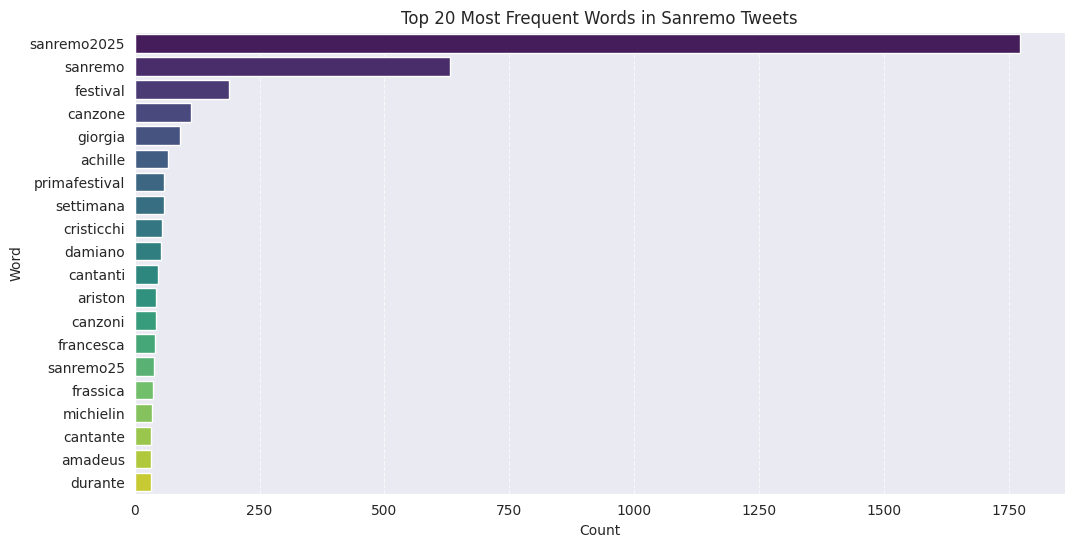

In [68]:
# Set style
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x="frequency", y="word", data=word_df, palette="viridis")

# Titles and labels
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Sanremo Tweets")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()

### Hashtags

In [69]:
from collections import Counter
import re


# Function to clean and extract words
def extract_words(text):
    words = re.findall(r"#\w+", text.lower())  # Extract hashtags
    return words

all_hashtags = df["text"].dropna().apply(extract_words)
hashtags = Counter([ht for sublist in all_hashtags for ht in sublist])
hashtags.most_common(10)

[('#sanremo2025', 1768),
 ('#sanremo', 91),
 ('#primafestival', 55),
 ('#sanremo25', 38),
 ('#fedez', 38),
 ('#fantasanremo', 18),
 ('#achillelauro', 17),
 ('#dopofestival', 16),
 ('#grandefratello', 15),
 ('#carloconti', 14)]

## Sentiment Analysis

In [70]:
from textblob import TextBlob

# Function to get sentiment polarity (-1 to 1)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
df["sentiment"] = df["text"].apply(get_sentiment)

# Average sentiment score
df["sentiment"].describe()


count    2046.000000
mean        0.015560
std         0.106125
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: sentiment, dtype: float64

In [71]:
# Tweets with most positive sentiment
df.sort_values(by="sentiment", ascending=False)[["username", "text", "sentiment"]].head(5)

,username,text,sentiment
id,,,
1194,InOgniSingolaRima,Carlo Conti e i best cocò della best serata 😎✨...,1.00
1445,GraceSomehow,"WELCOME TO SANREMO, BIENVENIDA A SANREMO 💀🤣 #...",0.80
703,Camilla桜,“Are you happy?” Vi prego Carlo Conti che parl...,0.80
1765,skuola.net,"Testi Sanremo 2025, Fuorilegge di Rose Villain...",0.75
1233,¥le 💐 Sanremo era 💐,QUESTA COSA MERAVIGLIOSA FATTA DA VANITY FAIR ...,0.70


In [72]:
# Tweets with most negative sentiment
df.sort_values(by="sentiment", ascending=True)[["username", "text", "sentiment"]].head(5)

,username,text,sentiment
id,,,
435,Camilla桜,Come spieghi a Dove Cameron cosa sta facendo F...,-1.0
223,Camilla桜,Il fatto che Luca Ravenna dovesse dire una fra...,-0.8
167,:):,Carlo Conti appena finisce la base del brano: ...,-0.8
1717,José Antonio Ayala,Tenemos un #Sanremo2025 sumamente exquisito do...,-0.6
902,¥le 💐 Sanremo era 💐,quando finisci squid game #Sanremo2025 #Prim...,-0.4
